## 1. Setup

In [109]:
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import pickle
import time
from datetime import datetime

from sentence_transformers import SentenceTransformer
import chromadb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import ollama

## 2. Load Existing Retrieval Systems

In [110]:
DATA_DIR = Path('processed_data')
VECTOR_STORE_DIR = Path('vector_stores')
RESULTS_DIR = Path('evaluation_results')
RESULTS_DIR.mkdir(exist_ok=True)

with open(VECTOR_STORE_DIR / 'retrieval_config.json', 'r') as f:
    config = json.load(f)

print("Retrieval Configuration:")
print(f"  Chunking methods: {config['chunking_methods']}")
print(f"  Retrieval methods: {config['retrieval_methods']}")
print(f"  Embedding models: {list(config['embedding_models'].keys())}")

Retrieval Configuration:
  Chunking methods: ['page', 'fixed_size', 'sentence']
  Retrieval methods: ['dense_nomic', 'dense_minilm', 'tfidf']
  Embedding models: ['nomic', 'minilm']


In [111]:
chunking_methods = config['chunking_methods']
chunks_data = {}

for method in chunking_methods:
    file_path = DATA_DIR / f'chunks_{method}.json'
    with open(file_path, 'r', encoding='utf-8') as f:
        chunks_data[method] = json.load(f)
    print(f"Loaded {len(chunks_data[method]):4d} chunks from {method}")

Loaded  881 chunks from page
Loaded 1540 chunks from fixed_size
Loaded 1577 chunks from sentence


In [112]:
ACTIVE_EMBEDDING = 'nomic'  

print(f"\nLoading embedding model: {ACTIVE_EMBEDDING}")
embedding_models = {}

if ACTIVE_EMBEDDING in ['nomic', 'both']:
    embedding_models['nomic'] = SentenceTransformer('nomic-ai/nomic-embed-text-v1.5', trust_remote_code=True, device='cuda')

if ACTIVE_EMBEDDING in ['minilm', 'both']:
    embedding_models['minilm'] = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')


Loading embedding model: nomic


<All keys matched successfully>


In [113]:
print("\nLoading ChromaDB collections")
chroma_client = chromadb.PersistentClient(path=str(VECTOR_STORE_DIR / 'chroma_db'))

chroma_collections = {}
for model_name in ['nomic', 'minilm']:
    chroma_collections[model_name] = {}
    for method in chunking_methods:
        collection_name = f"survival_{model_name}_{method}"
        chroma_collections[model_name][method] = chroma_client.get_collection(name=collection_name)
        print(f"{collection_name}")


Loading ChromaDB collections
survival_nomic_page
survival_nomic_fixed_size
survival_nomic_sentence
survival_minilm_page
survival_minilm_fixed_size
survival_minilm_sentence


In [114]:
print("\nLoading TF-IDF indices")
tfidf_indices = {}

for method in chunking_methods:
    tfidf_file = VECTOR_STORE_DIR / f'tfidf_{method}.pkl'
    with open(tfidf_file, 'rb') as f:
        tfidf_data = pickle.load(f)
    tfidf_indices[method] = tfidf_data
    print(f"tfidf_{method}.pkl")


Loading TF-IDF indices
tfidf_page.pkl
tfidf_fixed_size.pkl
tfidf_sentence.pkl


## 3. Recreate Retrieval System Class

In [115]:
class RetrievalSystem:
    
    def __init__(self, method_name, chunks, chroma_collections, tfidf_index, embedding_models):
        self.method_name = method_name
        self.chunks = chunks
        self.chroma_collections = chroma_collections
        self.tfidf_vectorizer = tfidf_index['vectorizer']
        self.tfidf_matrix = tfidf_index['matrix']
        self.embedding_models = embedding_models
    
    def dense_retrieval(self, query, model_name='nomic', top_k=5):
        query_embedding = self.embedding_models[model_name].encode([query])[0]
        
        results = self.chroma_collections[model_name].query(
            query_embeddings=[query_embedding.tolist()],
            n_results=top_k,
            include=['documents', 'embeddings', 'distances']
        )
        
        retrieved_docs = []
        for i, (doc_id, doc, stored_embedding) in enumerate(zip(
            results['ids'][0],
            results['documents'][0],
            results['embeddings'][0]
        )):
            stored_emb_array = np.array(stored_embedding)
            
            dot_product = np.dot(query_embedding, stored_emb_array)
            query_norm = np.linalg.norm(query_embedding)
            stored_norm = np.linalg.norm(stored_emb_array)
            
            cosine_sim = dot_product / (query_norm * stored_norm)
            similarity = float(np.clip(cosine_sim, 0.0, 1.0))
            
            retrieved_docs.append({
                'rank': i + 1,
                'chunk_id': doc_id,
                'text': doc,
                'score': similarity,
                'method': f'dense_{model_name}'
            })
        
        return retrieved_docs
    
    def tfidf_retrieval(self, query, top_k=5):
        query_vector = self.tfidf_vectorizer.transform([query])
        similarities = cosine_similarity(query_vector, self.tfidf_matrix).flatten()
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        retrieved_docs = []
        for i, idx in enumerate(top_indices):
            chunk = self.chunks[idx]
            retrieved_docs.append({
                'rank': i + 1,
                'chunk_id': chunk['chunk_id'],
                'text': chunk['text'],
                'score': float(similarities[idx]),
                'method': 'tfidf'
            })
        
        return retrieved_docs
    
    def retrieve(self, query, method='dense_nomic', top_k=5):
        if method == 'dense_nomic':
            return self.dense_retrieval(query, model_name='nomic', top_k=top_k)
        elif method == 'dense_minilm':
            return self.dense_retrieval(query, model_name='minilm', top_k=top_k)
        elif method == 'tfidf':
            return self.tfidf_retrieval(query, top_k=top_k)
        else:
            raise ValueError(f"Unknown method: {method}")

retrieval_systems = {}

for method in chunking_methods:
    retrieval_systems[method] = RetrievalSystem(
        method_name=method,
        chunks=chunks_data[method],
        chroma_collections={
            'nomic': chroma_collections['nomic'][method],
            'minilm': chroma_collections['minilm'][method]
        },
        tfidf_index=tfidf_indices[method],
        embedding_models=embedding_models
    )

## 4. Setup Local LLMs via Ollama

I'll use two distinct models:
1. **Gemma 3 4B**
2. **Mistral 7B** 

Both run via Ollama for efficient quantization and proper VRAM management.

In [116]:
ACTIVE_LLM = 'gemma3'
LLM_MODELS_CONFIG = {
    'gemma3': {'name': 'gemma3:4b'},  
    'mistral': {'name': 'mistral:7b'}  
}

print(f"\nActive LLM: {ACTIVE_LLM}")
print(f"Available LLMs: {list(LLM_MODELS_CONFIG.keys())}")


Active LLM: gemma3
Available LLMs: ['gemma3', 'mistral']


In [117]:
try:
    response = ollama.chat(
        model=LLM_MODELS_CONFIG[ACTIVE_LLM]['name'],
        messages=[{'role': 'user', 'content': 'Say hello'}],
        options={'num_predict': 10}
    )
    print(f"{ACTIVE_LLM} ({LLM_MODELS_CONFIG[ACTIVE_LLM]['name']}): Working")
except Exception as e:
    print(f"{ACTIVE_LLM}: {e}")
   

gemma3 (gemma3:4b): Working


## 5. Implement RAG Pipeline

## 5.5 Advanced Evaluation Metrics

Additional metrics to better evaluate RAG quality:
1. **Precision@K**: Relevance of retrieved chunks
2. **Recall**: Coverage of relevant information  
3. **Mean Reciprocal Rank**: Position of first relevant chunk
4. **Context Overlap**: Token overlap between answer and context 
5. **Answer Relevance**: Semantic similarity between answer and context

In [118]:
from sklearn.feature_extraction.text import CountVectorizer

def calculate_context_overlap(answer, context_docs):
    """
    Calculate token overlap between answer and retrieved context.
    Measures faithfulness (how much answer is grounded in context).
    
    Returns: float [0-1] - proportion of answer tokens found in context
    """
    if not answer or not context_docs:
        return 0.0
    
    context_text = " ".join([doc['text'] for doc in context_docs])
    
    try:
        vectorizer = CountVectorizer().fit([context_text, answer])
        context_vec = vectorizer.transform([context_text]).toarray()[0]
        answer_vec = vectorizer.transform([answer]).toarray()[0]
        
        overlap = np.minimum(context_vec, answer_vec).sum()
        total_answer_tokens = answer_vec.sum()
        
        return overlap / total_answer_tokens if total_answer_tokens > 0 else 0.0
    except:
        return 0.0


def calculate_answer_relevance(answer, context_docs, embedding_model):
    """
    Calculate semantic similarity between answer and retrieved context.
    Uses cosine similarity of embeddings.
    
    Returns: float [0-1] - max cosine similarity to any context chunk
    """
    if not answer or not context_docs:
        return 0.0
    
    try:
        answer_emb = embedding_model.encode(answer, convert_to_tensor=False)
        context_texts = [doc['text'] for doc in context_docs]
        context_embs = embedding_model.encode(context_texts, convert_to_tensor=False)
        
        similarities = cosine_similarity([answer_emb], context_embs)[0]
        
        return float(np.max(similarities))
    except:
        return 0.0


def calculate_precision_at_k(retrieved_docs, k=3):
    """
    Normalized Precision@K: Average of retrieval scores for top-K documents.
    Uses actual scores as continuous relevance measure.
    
    Score interpretation:
    - 1.0 = perfect relevance for all top-K docs
    - 0.0 = no relevance
    
    Returns: float [0-1] - normalized average score of top-K documents
    """
    if not retrieved_docs or k == 0:
        return 0.0
    
    top_k = retrieved_docs[:k]
    
    avg_score = np.mean([doc['score'] for doc in top_k])
    
    return float(np.clip(avg_score, 0.0, 1.0))


def calculate_recall(retrieved_docs):
    """
    Normalized Recall: Measures coverage using score-weighted relevance.
    
    Uses DCG-inspired approach: sum of scores divided by ideal sum (all scores = 1.0)
    This gives continuous measure without arbitrary thresholds.
    
    Returns: float [0-1] - proportion of potential relevance captured
    """
    if not retrieved_docs:
        return 0.0
    
    actual_relevance = sum(doc['score'] for doc in retrieved_docs)
    
    ideal_relevance = len(retrieved_docs)
    
    return float(np.clip(actual_relevance / ideal_relevance, 0.0, 1.0))


def calculate_mrr(retrieved_docs):
    """
    Normalized MRR: Uses score-weighted reciprocal rank.
    
    Combines rank position with score strength:
    - High score at rank 1 → close to 1.0
    - Low scores or low ranks → lower values
    
    Returns: float [0-1] - score-weighted reciprocal rank
    """
    if not retrieved_docs:
        return 0.0
    
    weighted_scores = []
    for rank, doc in enumerate(retrieved_docs, start=1):
        weighted_score = doc['score'] * (1.0 / rank)
        weighted_scores.append(weighted_score)
    
    mrr = max(weighted_scores) if weighted_scores else 0.0
    
    return float(np.clip(mrr, 0.0, 1.0))

In [119]:
def generate_answer(query, context_docs, llm_name='gemma3', max_tokens=250):
    """
    Generate answer using retrieved context and LLM via Ollama.
    
    Args:
        query: User question
        context_docs: List of retrieved document dicts with 'text' field
        llm_name: 'gemma3' or 'mistral'
        max_tokens: Maximum length of generated answer
    """
    context = "\n\n".join([f"[{i+1}] {doc['text'][:400]}" for i, doc in enumerate(context_docs)])
    
    system_prompt = """You are a famous survival expert Bear Grylls, trained on US Army Field Manuals FM 21-76 and FM 3-05-70. 
                    Provide practical, actionable advice based on the provided context. 
                    Try to act natural as a human would and rephrase the context if necessary.
                    Do not mention you are using the context, pretend it's your own knowledge.
                    Keep the answer short up to 200 words"""
    
    user_prompt = f"""Context from survival manuals:
{context}

Question: {query}

Answer:"""
    
    model_name = LLM_MODELS_CONFIG[llm_name]['name']
    
    start_time = time.time()
    try:
        response = ollama.chat(
            model=model_name,
            messages=[
                {'role': 'system', 'content': system_prompt},
                {'role': 'user', 'content': user_prompt}
            ],
            options={
                'temperature': 0.7,
                'top_p': 0.9,
                'num_predict': max_tokens
            }
        )
        answer = response['message']['content'].strip()
    except Exception as e:
        answer = f"[ERROR: {str(e)}]"
    
    generation_time = time.time() - start_time
    
    return {
        'answer': answer,
        'generation_time': generation_time,
        'context_used': len(context_docs)
    }

## 6. Define Test Questions

In [120]:
test_questions = [
    "How do I find water in the desert?",
    "What should I do if I encounter a venomous snake?",
    "How can I build a shelter in cold weather?",
    "What are the best methods to purify water for drinking?",
    "How do I start a fire without matches?",
    "What plants are safe to eat in a survival situation?",
    "How can I signal for rescue?",
    "What should I do if I get lost in the wilderness?",
    "How do I treat a broken bone in the wilderness?",
    "What are the signs of hypothermia and how do I treat it?",
]

print(f"Prepared {len(test_questions)} test questions")
for i, q in enumerate(test_questions, 1):
    print(f"  {i}. {q}")

Prepared 10 test questions
  1. How do I find water in the desert?
  2. What should I do if I encounter a venomous snake?
  3. How can I build a shelter in cold weather?
  4. What are the best methods to purify water for drinking?
  5. How do I start a fire without matches?
  6. What plants are safe to eat in a survival situation?
  7. How can I signal for rescue?
  8. What should I do if I get lost in the wilderness?
  9. How do I treat a broken bone in the wilderness?
  10. What are the signs of hypothermia and how do I treat it?


## 6.5 Interactive Chat Test



In [121]:
question = "How to consume raw fish I found in the lake safely?"

CHAT_CHUNKING = 'page'       
CHAT_RETRIEVAL = 'dense_nomic'  
CHAT_LLM = ACTIVE_LLM          
CHAT_TOP_K = 3

print(f"Config: chunking={CHAT_CHUNKING} | retrieval={CHAT_RETRIEVAL} | llm={CHAT_LLM} | top_k={CHAT_TOP_K}")
print(f"Question: {question}")

retriever = retrieval_systems[CHAT_CHUNKING]
retrieved_docs = retriever.retrieve(question, method=CHAT_RETRIEVAL, top_k=CHAT_TOP_K)

print(f"Found {len(retrieved_docs)} relevant chunks (avg score: {np.mean([d['score'] for d in retrieved_docs]):.4f})")
print(f"\n{'─'*100}")

result = generate_answer(question, retrieved_docs, llm_name=CHAT_LLM, max_tokens=500)

print(f"\nSurvival expert: ({result['generation_time']:.2f}s):\n")
print(result['answer'])

Config: chunking=page | retrieval=dense_nomic | llm=gemma3 | top_k=3
Question: How to consume raw fish I found in the lake safely?
Found 3 relevant chunks (avg score: 0.7101)

────────────────────────────────────────────────────────────────────────────────────────────────────

Survival expert: (6.06s):

Right, let’s talk about this raw fish. It’s a valuable find, absolutely. But we need to be smart about this. 

Firstly, the further out you’ve caught it, the safer it generally is. Moving closer to shore increases the risk of poisonous species. 

Now, raw fish needs to be treated with respect. Thoroughly cook it. Fire is your friend here. Cooking eliminates the risk of parasites and toxins. 

Don’t take chances. If you’re unsure about the fish’s origin or its appearance – don’t eat it. 

Always prioritize safety. A little hunger is far preferable to serious illness.

Survival expert: (6.06s):

Right, let’s talk about this raw fish. It’s a valuable find, absolutely. But we need to be sma

## 7. Run Complete Evaluation

Test all combinations:
3 chunking strategies * 3 retrieval methods * 2 LLMs = 18 configurations per question

In [126]:
TFIDF_CONFIGS = [
    {'llm': 'gemma3', 'embedding': None, 'retrieval': 'tfidf'},
    {'llm': 'mistral', 'embedding': None, 'retrieval': 'tfidf'}
]

EMBEDDING_CONFIGS = [
    {'llm': 'gemma3', 'embedding': 'nomic'},
    {'llm': 'gemma3', 'embedding': 'minilm'},
    {'llm': 'mistral', 'embedding': 'nomic'},
    {'llm': 'mistral', 'embedding': 'minilm'}
]

CHUNKING_METHODS = chunking_methods
TOP_K = 3

tfidf_evals = len(TFIDF_CONFIGS) * 3 * len(test_questions) 
embedding_evals = len(EMBEDDING_CONFIGS) * 3 * len(test_questions) 
total_evals = tfidf_evals + embedding_evals

print(f"\nTF-IDF Baseline:")
for i, cfg in enumerate(TFIDF_CONFIGS, 1):
    print(f"  Config {i}: {cfg['llm']:8s} + TF-IDF")
print(f"  Subtotal: {tfidf_evals} evaluations")

print(f"\nEmbedding-Based Retrieval:")
for i, cfg in enumerate(EMBEDDING_CONFIGS, 1):
    print(f"  Config {i+len(TFIDF_CONFIGS)}: {cfg['llm']:8s} + {cfg['embedding']:6s}")
print(f"  Subtotal: {embedding_evals} evaluations")


TF-IDF Baseline:
  Config 1: gemma3   + TF-IDF
  Config 2: mistral  + TF-IDF
  Subtotal: 60 evaluations

Embedding-Based Retrieval:
  Config 3: gemma3   + nomic 
  Config 4: gemma3   + minilm
  Config 5: mistral  + nomic 
  Config 6: mistral  + minilm
  Subtotal: 120 evaluations


In [127]:
RETRIEVAL_METHODS = ['tfidf', 'dense_nomic', 'dense_minilm']

In [128]:
import gc
import torch

all_results = []
test_questions_subset = test_questions

print(f"Starting evaluation at {datetime.now().strftime('%H:%M:%S')}")

print("TF-IDF BASELINE")

for config_idx, config in enumerate(TFIDF_CONFIGS, 1):
    print(f"TF-IDF CONFIG {config_idx}/{len(TFIDF_CONFIGS)}: LLM={config['llm']}, Retrieval=TF-IDF")
    
    print(f"Starting {len(test_questions_subset)} questions...")
    
    for q_idx, question in enumerate(test_questions_subset, 1):
        print(f"Q{q_idx}/{len(test_questions_subset)}: {question[:60]}...")
        
        for chunking in CHUNKING_METHODS:
            retriever = retrieval_systems[chunking]
            
            retrieved_docs = retriever.retrieve(question, method='tfidf', top_k=TOP_K)
            
            result = generate_answer(question, retrieved_docs, llm_name=config['llm'], max_tokens=200)
            answer = result['answer']
            
            context_overlap = calculate_context_overlap(answer, retrieved_docs)
            precision_at_k = calculate_precision_at_k(retrieved_docs, k=TOP_K)
            recall = calculate_recall(retrieved_docs)
            mrr = calculate_mrr(retrieved_docs)
            
            all_results.append({
                'config': f"{config['llm']}+tfidf",
                'question': question,
                'chunking': chunking,
                'retrieval': 'tfidf',
                'llm': config['llm'],
                'embedding': 'none',
                'answer': answer,
                'generation_time': result['generation_time'],
                'top_retrieval_scores': [doc['score'] for doc in retrieved_docs],
                'avg_retrieval_score': np.mean([doc['score'] for doc in retrieved_docs]),
                'retrieved_chunks': [doc['chunk_id'] for doc in retrieved_docs],
                'context_overlap': context_overlap,
                'answer_relevance': 0.0,
                'precision_at_k': precision_at_k,
                'recall': recall,
                'mrr': mrr
            })
    
    config_name = f"{config['llm']}+tfidf"
    config_count = len([r for r in all_results if r['config'] == config_name])
    print(f"TF-IDF Config {config_idx} complete: {config_count} results\n")

print(f"TF-IDF Baseline complete: {len(all_results)} results\n")

print("EMBEDDING-BASED RETRIEVAL")

current_embedding = None

for config_idx, config in enumerate(EMBEDDING_CONFIGS, 1):
    print(f"EMBEDDING CONFIG {config_idx}/{len(EMBEDDING_CONFIGS)}: LLM={config['llm']}, Embedding={config['embedding']}")
   
    if current_embedding is not None:
        print(f"Cleaning up previous embedding model from VRAM...")
        del current_embedding
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    print(f"Loading {config['embedding']} embedding model...")
    current_embedding = {}
    if config['embedding'] == 'nomic':
        current_embedding['nomic'] = SentenceTransformer('nomic-ai/nomic-embed-text-v1.5', trust_remote_code=True, device='cuda')
        retrieval_method = 'dense_nomic'
    else:
        current_embedding['minilm'] = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')
        retrieval_method = 'dense_minilm'
    
    for method in CHUNKING_METHODS:
        retrieval_systems[method].embedding_models = current_embedding
    
    print(f"Starting {len(test_questions_subset)} questions...")
    
    for q_idx, question in enumerate(test_questions_subset, 1):
        print(f"Q{q_idx}/{len(test_questions_subset)}: {question[:60]}...")
        
        for chunking in CHUNKING_METHODS:
            retriever = retrieval_systems[chunking]
            
            retrieved_docs = retriever.retrieve(question, method=retrieval_method, top_k=TOP_K)
            
            result = generate_answer(question, retrieved_docs, llm_name=config['llm'], max_tokens=200)
            answer = result['answer']
            
            emb_model = current_embedding.get('nomic') or current_embedding.get('minilm')
            context_overlap = calculate_context_overlap(answer, retrieved_docs)
            answer_relevance = calculate_answer_relevance(answer, retrieved_docs, emb_model)
            precision_at_k = calculate_precision_at_k(retrieved_docs, k=TOP_K)
            recall = calculate_recall(retrieved_docs)
            mrr = calculate_mrr(retrieved_docs)
            
            all_results.append({
                'config': f"{config['llm']}+{config['embedding']}",
                'question': question,
                'chunking': chunking,
                'retrieval': retrieval_method,
                'llm': config['llm'],
                'embedding': config['embedding'],
                'answer': answer,
                'generation_time': result['generation_time'],
                'top_retrieval_scores': [doc['score'] for doc in retrieved_docs],
                'avg_retrieval_score': np.mean([doc['score'] for doc in retrieved_docs]),
                'retrieved_chunks': [doc['chunk_id'] for doc in retrieved_docs],
                'context_overlap': context_overlap,
                'answer_relevance': answer_relevance,
                'precision_at_k': precision_at_k,
                'recall': recall,
                'mrr': mrr
            })
    
    config_name = f"{config['llm']}+{config['embedding']}"
    config_count = len([r for r in all_results if r['config'] == config_name])
    print(f"Embedding Config {config_idx} complete: {config_count} results\n")

print(f"Final cleanup: Removing last embedding model from VRAM...")
if current_embedding is not None:
    del current_embedding
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
print(f"VRAM fully cleaned\n")

print(f"All configs completed at {datetime.now().strftime('%H:%M:%S')}")
print(f"Total results: {len(all_results)}")
print(f"  TF-IDF baseline: {len([r for r in all_results if r['retrieval'] == 'tfidf'])} results")
print(f"  Embedding-based: {len([r for r in all_results if r['retrieval'] != 'tfidf'])} results")

Starting evaluation at 00:50:21
TF-IDF BASELINE
TF-IDF CONFIG 1/2: LLM=gemma3, Retrieval=TF-IDF
Starting 10 questions...
Q1/10: How do I find water in the desert?...
Q2/10: What should I do if I encounter a venomous snake?...
Q2/10: What should I do if I encounter a venomous snake?...
Q3/10: How can I build a shelter in cold weather?...
Q3/10: How can I build a shelter in cold weather?...
Q4/10: What are the best methods to purify water for drinking?...
Q4/10: What are the best methods to purify water for drinking?...
Q5/10: How do I start a fire without matches?...
Q5/10: How do I start a fire without matches?...
Q6/10: What plants are safe to eat in a survival situation?...
Q6/10: What plants are safe to eat in a survival situation?...
Q7/10: How can I signal for rescue?...
Q7/10: How can I signal for rescue?...
Q8/10: What should I do if I get lost in the wilderness?...
Q8/10: What should I do if I get lost in the wilderness?...
Q9/10: How do I treat a broken bone in the wilderness?

<All keys matched successfully>


Starting 10 questions...
Q1/10: How do I find water in the desert?...
Q2/10: What should I do if I encounter a venomous snake?...
Q2/10: What should I do if I encounter a venomous snake?...
Q3/10: How can I build a shelter in cold weather?...
Q3/10: How can I build a shelter in cold weather?...
Q4/10: What are the best methods to purify water for drinking?...
Q4/10: What are the best methods to purify water for drinking?...
Q5/10: How do I start a fire without matches?...
Q5/10: How do I start a fire without matches?...
Q6/10: What plants are safe to eat in a survival situation?...
Q6/10: What plants are safe to eat in a survival situation?...
Q7/10: How can I signal for rescue?...
Q7/10: How can I signal for rescue?...
Q8/10: What should I do if I get lost in the wilderness?...
Q8/10: What should I do if I get lost in the wilderness?...
Q9/10: How do I treat a broken bone in the wilderness?...
Q9/10: How do I treat a broken bone in the wilderness?...
Q10/10: What are the signs of hypo

<All keys matched successfully>


Starting 10 questions...
Q1/10: How do I find water in the desert?...
Q2/10: What should I do if I encounter a venomous snake?...
Q2/10: What should I do if I encounter a venomous snake?...
Q3/10: How can I build a shelter in cold weather?...
Q3/10: How can I build a shelter in cold weather?...
Q4/10: What are the best methods to purify water for drinking?...
Q4/10: What are the best methods to purify water for drinking?...
Q5/10: How do I start a fire without matches?...
Q5/10: How do I start a fire without matches?...
Q6/10: What plants are safe to eat in a survival situation?...
Q6/10: What plants are safe to eat in a survival situation?...
Q7/10: How can I signal for rescue?...
Q7/10: How can I signal for rescue?...
Q8/10: What should I do if I get lost in the wilderness?...
Q8/10: What should I do if I get lost in the wilderness?...
Q9/10: How do I treat a broken bone in the wilderness?...
Q9/10: How do I treat a broken bone in the wilderness?...
Q10/10: What are the signs of hypo

## 8. Save Results

In [129]:
results_df = pd.DataFrame(all_results)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_file = RESULTS_DIR / f'rag_evaluation_all_configs_{timestamp}.csv'
results_df.to_csv(results_file, index=False, encoding='utf-8')

print(f"Results saved to: {results_file}")
print(f"\nDataFrame shape: {results_df.shape}")
print(f"\nResults per config:")
print(results_df.groupby('config').size())
print(f"\nFirst few results:")
results_df.head()

Results saved to: evaluation_results\rag_evaluation_all_configs_20251119_011021.csv

DataFrame shape: (180, 16)

Results per config:
config
gemma3+minilm     30
gemma3+nomic      30
gemma3+tfidf      30
mistral+minilm    30
mistral+nomic     30
mistral+tfidf     30
dtype: int64

First few results:


,config,question,chunking,retrieval,llm,embedding,answer,generation_time,top_retrieval_scores,avg_retrieval_score,retrieved_chunks,context_overlap,answer_relevance,precision_at_k,recall,mrr
0,gemma3+tfidf,How do I find water in the desert?,page,tfidf,gemma3,none,"Right, let’s talk about water in the desert – ...",7.749776,"[0.2890160701707482, 0.19247509829289997, 0.17...",0.217467,"[FM3-05-70_page_454, FM3-05-70_page_218, FM3-0...",0.529412,0.0,0.217467,0.217467,0.289016
1,gemma3+tfidf,How do I find water in the desert?,fixed_size,tfidf,gemma3,none,"Right, let’s talk about water in the desert – ...",6.297480,"[0.1824746422684207, 0.18231191267656727, 0.17...",0.178721,"[FM21-76_fixed_305, FM21-76_fixed_312, FM3-05-...",0.509434,0.0,0.178721,0.178721,0.182475
2,gemma3+tfidf,How do I find water in the desert?,sentence,tfidf,gemma3,none,"Right, let’s talk about water in the desert – ...",7.297866,"[0.22733603690592116, 0.20078346259946706, 0.2...",0.209446,"[FM21-76_sent_302, FM3-05-70_sent_403, FM3-05-...",0.389381,0.0,0.209446,0.209446,0.227336
3,gemma3+tfidf,What should I do if I encounter a venomous snake?,page,tfidf,gemma3,none,"Right, let’s get this straight. Encountering a...",7.327384,"[0.24533648697219507, 0.21403577424728537, 0.1...",0.211256,"[FM3-05-70_page_532, FM3-05-70_page_587, FM3-0...",0.437500,0.0,0.211256,0.211256,0.245336
4,gemma3+tfidf,What should I do if I encounter a venomous snake?,fixed_size,tfidf,gemma3,none,"Right, let’s get this sorted. If you spot a ve...",6.847677,"[0.30562994797971665, 0.19870754923677225, 0.1...",0.222403,"[FM3-05-70_fixed_834, FM3-05-70_fixed_872, FM3...",0.436364,0.0,0.222403,0.222403,0.305630


In [130]:
json_file = RESULTS_DIR / f'rag_evaluation_all_configs_detailed_{timestamp}.json'
with open(json_file, 'w', encoding='utf-8') as f:
    json.dump(all_results, f, indent=2, ensure_ascii=False)

print(f"Detailed results saved to: {json_file}")
print(f"Configs included: {results_df['config'].unique().tolist()}")

Detailed results saved to: evaluation_results\rag_evaluation_all_configs_detailed_20251119_011021.json
Configs included: ['gemma3+tfidf', 'mistral+tfidf', 'gemma3+nomic', 'gemma3+minilm', 'mistral+nomic', 'mistral+minilm']


## 9. Analysis: Compare Retrieval Methods

In [131]:
print("RETRIEVAL METHODS COMPARISON")

retrieval_analysis = results_df.groupby('retrieval').agg({
    'avg_retrieval_score': ['mean', 'std'],
    'generation_time': ['mean', 'std']
}).round(4)
print(retrieval_analysis)

print("BY CONFIG:")
retrieval_by_config = results_df.groupby(['config', 'retrieval']).agg({
    'avg_retrieval_score': 'mean',
    'precision_at_k': 'mean',
    'mrr': 'mean'
}).round(4)
print(retrieval_by_config)

RETRIEVAL METHODS COMPARISON
             avg_retrieval_score         generation_time        
                            mean     std            mean     std
retrieval                                                       
dense_minilm              0.6361  0.0702          5.0364  1.4789
dense_nomic               0.7658  0.0449          5.7050  1.9382
tfidf                     0.1932  0.0447          8.3609  2.0585
BY CONFIG:
                             avg_retrieval_score  precision_at_k     mrr
config         retrieval                                                
gemma3+minilm  dense_minilm               0.6361          0.6361  0.6676
gemma3+nomic   dense_nomic                0.7658          0.7658  0.7803
gemma3+tfidf   tfidf                      0.1932          0.1932  0.2203
mistral+minilm dense_minilm               0.6361          0.6361  0.6676
mistral+nomic  dense_nomic                0.7658          0.7658  0.7803
mistral+tfidf  tfidf                      0.1932          0

## 9.5 Advanced Metrics Analysis

In [132]:

print("MORE METRICS SUMMARY (All Configs)")

metrics_summary = results_df[['context_overlap', 'answer_relevance', 'precision_at_k', 'recall', 'mrr']].describe()
print(metrics_summary.round(4))

print("METRICS BY CONFIG")
metrics_by_config = results_df.groupby('config').agg({
    'avg_retrieval_score': 'mean',
    'context_overlap': 'mean',
    'answer_relevance': 'mean',
    'precision_at_k': 'mean',
    'recall': 'mean',
    'mrr': 'mean',
    'generation_time': 'mean'
}).round(4)
print(metrics_by_config)

print("METRICS BY RETRIEVAL METHOD")
advanced_metrics_by_retrieval = results_df.groupby('retrieval').agg({
    'context_overlap': ['mean', 'std'],
    'answer_relevance': ['mean', 'std'],
    'precision_at_k': ['mean', 'std'],
    'recall': ['mean', 'std'],
    'mrr': ['mean', 'std']
}).round(4)
print(advanced_metrics_by_retrieval)

print("METRICS BY CHUNKING STRATEGY")
advanced_metrics_by_chunking = results_df.groupby('chunking').agg({
    'context_overlap': ['mean', 'std'],
    'answer_relevance': ['mean', 'std'],
    'precision_at_k': ['mean', 'std'],
    'recall': ['mean', 'std'],
    'mrr': ['mean', 'std']
}).round(4)
print(advanced_metrics_by_chunking)

MORE METRICS SUMMARY (All Configs)
       context_overlap  answer_relevance  precision_at_k    recall       mrr
count         180.0000          180.0000        180.0000  180.0000  180.0000
mean            0.5895            0.5362          0.5317    0.5317    0.5561
std             0.1143            0.3884          0.2518    0.2518    0.2502
min             0.2923            0.0000          0.1072    0.1072    0.1126
25%             0.5268            0.0000          0.2247    0.2247    0.2677
50%             0.5834            0.7474          0.6545    0.6545    0.6847
75%             0.6531            0.8558          0.7352    0.7352    0.7491
max             0.9389            0.9403          0.8363    0.8363    0.8538
METRICS BY CONFIG
                avg_retrieval_score  context_overlap  answer_relevance  \
config                                                                   
gemma3+minilm                0.6361           0.5656            0.6987   
gemma3+nomic                 0.7

## 10. Analysis: Compare Chunking Strategies

In [135]:
chunking_analysis = results_df.groupby('chunking').agg({
    'avg_retrieval_score': ['mean', 'std'],
    'generation_time': ['mean', 'std']
}).round(4)

print("CHUNKING STRATEGIES COMPARISON")
print(chunking_analysis)
print("\nChunk counts:")
for method in chunking_methods:
    print(f"{method}: {len(chunks_data[method])} chunks")

CHUNKING STRATEGIES COMPARISON
           avg_retrieval_score         generation_time        
                          mean     std            mean     std
chunking                                                      
fixed_size              0.5394  0.2558          6.2434  2.2289
page                    0.5201  0.2521          6.6700  2.6905
sentence                0.5356  0.2513          6.1888  2.0305

Chunk counts:
page: 881 chunks
fixed_size: 1540 chunks
sentence: 1577 chunks


## 11. Analysis: Compare LLMs

In [136]:
llm_analysis = results_df.groupby('llm').agg({
    'generation_time': ['mean', 'std', 'min', 'max'],
    'answer': 'count'
}).round(4)

print("LLM MODELS COMPARISON")
print(llm_analysis)

results_df['answer_length'] = results_df['answer'].str.len()
answer_length_stats = results_df.groupby('llm')['answer_length'].agg(['mean', 'std', 'min', 'max']).round(0)
print("\nAnswer length (characters):")
print(answer_length_stats)

LLM MODELS COMPARISON
        generation_time                          answer
                   mean     std     min      max  count
llm                                                    
gemma3           6.7656  1.0095  4.4148  12.6040     90
mistral          5.9692  3.0950  1.8041  15.3464     90

Answer length (characters):
          mean    std  min  max
llm                            
gemma3   693.0   66.0  539  859
mistral  746.0  125.0  308  927


## 12. Best Configuration Analysis

In [137]:
combination_analysis = results_df.groupby(['chunking', 'retrieval', 'llm']).agg({
    'avg_retrieval_score': 'mean',
    'generation_time': 'mean'
}).round(4).sort_values('avg_retrieval_score', ascending=False)

print("TOP OF CONFIGURATIONS (by retrieval quality)")
print(combination_analysis.head(10))

print("FASTEST CONFIGURATIONS (by generation time)")
print(combination_analysis.sort_values('generation_time').head(10))

TOP OF CONFIGURATIONS (by retrieval quality)
                                 avg_retrieval_score  generation_time
chunking   retrieval    llm                                          
fixed_size dense_nomic  gemma3                0.7736           7.0156
                        mistral               0.7736           3.9358
sentence   dense_nomic  mistral               0.7684           4.3839
                        gemma3                0.7684           7.0687
page       dense_nomic  mistral               0.7554           4.1907
                        gemma3                0.7554           7.6351
fixed_size dense_minilm mistral               0.6484           3.8495
                        gemma3                0.6484           5.9956
sentence   dense_minilm gemma3                0.6391           6.2339
                        mistral               0.6391           3.8543
FASTEST CONFIGURATIONS (by generation time)
                                 avg_retrieval_score  generation_time
c

## 13. Example Answers Comparison

In [138]:
example_question = test_questions[0]
example_results = results_df[results_df['question'] == example_question]

print(f"EXAMPLE ANSWERS FOR: '{example_question}'")

for retrieval in RETRIEVAL_METHODS:
    subset = example_results[example_results['retrieval'] == retrieval]
    best_config = subset.loc[subset['avg_retrieval_score'].idxmax()]
    
    print(f"\n{'─'*100}")
    print(f"Retrieval: {best_config['retrieval']} | Chunking: {best_config['chunking']} | LLM: {best_config['llm']}")
    print(f"Score: {best_config['avg_retrieval_score']:.4f} | Time: {best_config['generation_time']:.2f}s")
    print(f"{'─'*100}")
    print(best_config['answer'])
    print()

EXAMPLE ANSWERS FOR: 'How do I find water in the desert?'

────────────────────────────────────────────────────────────────────────────────────────────────────
Retrieval: tfidf | Chunking: page | LLM: gemma3
Score: 0.2175 | Time: 7.75s
────────────────────────────────────────────────────────────────────────────────────────────────────
Right, let’s talk about water in the desert – it’s absolutely critical. You’re going to be looking for a few key things. 

Firstly, the pincushion cactus, *Mammilaria*, can be a lifeline. These barrel-shaped cacti hold a surprising amount of water, but be *extremely* careful – those spines are vicious. Approach with caution, and only consume the pulp if you’re certain of its identification. 

Beyond that, you need to be constantly scanning for any signs of moisture. Look for depressions in the ground, especially after a rainfall, as these can collect rainwater.  And remember, heat plays tricks on your eyes – don't trust what you see. Get to higher ground;

## 14. Visualization: Performance Comparison

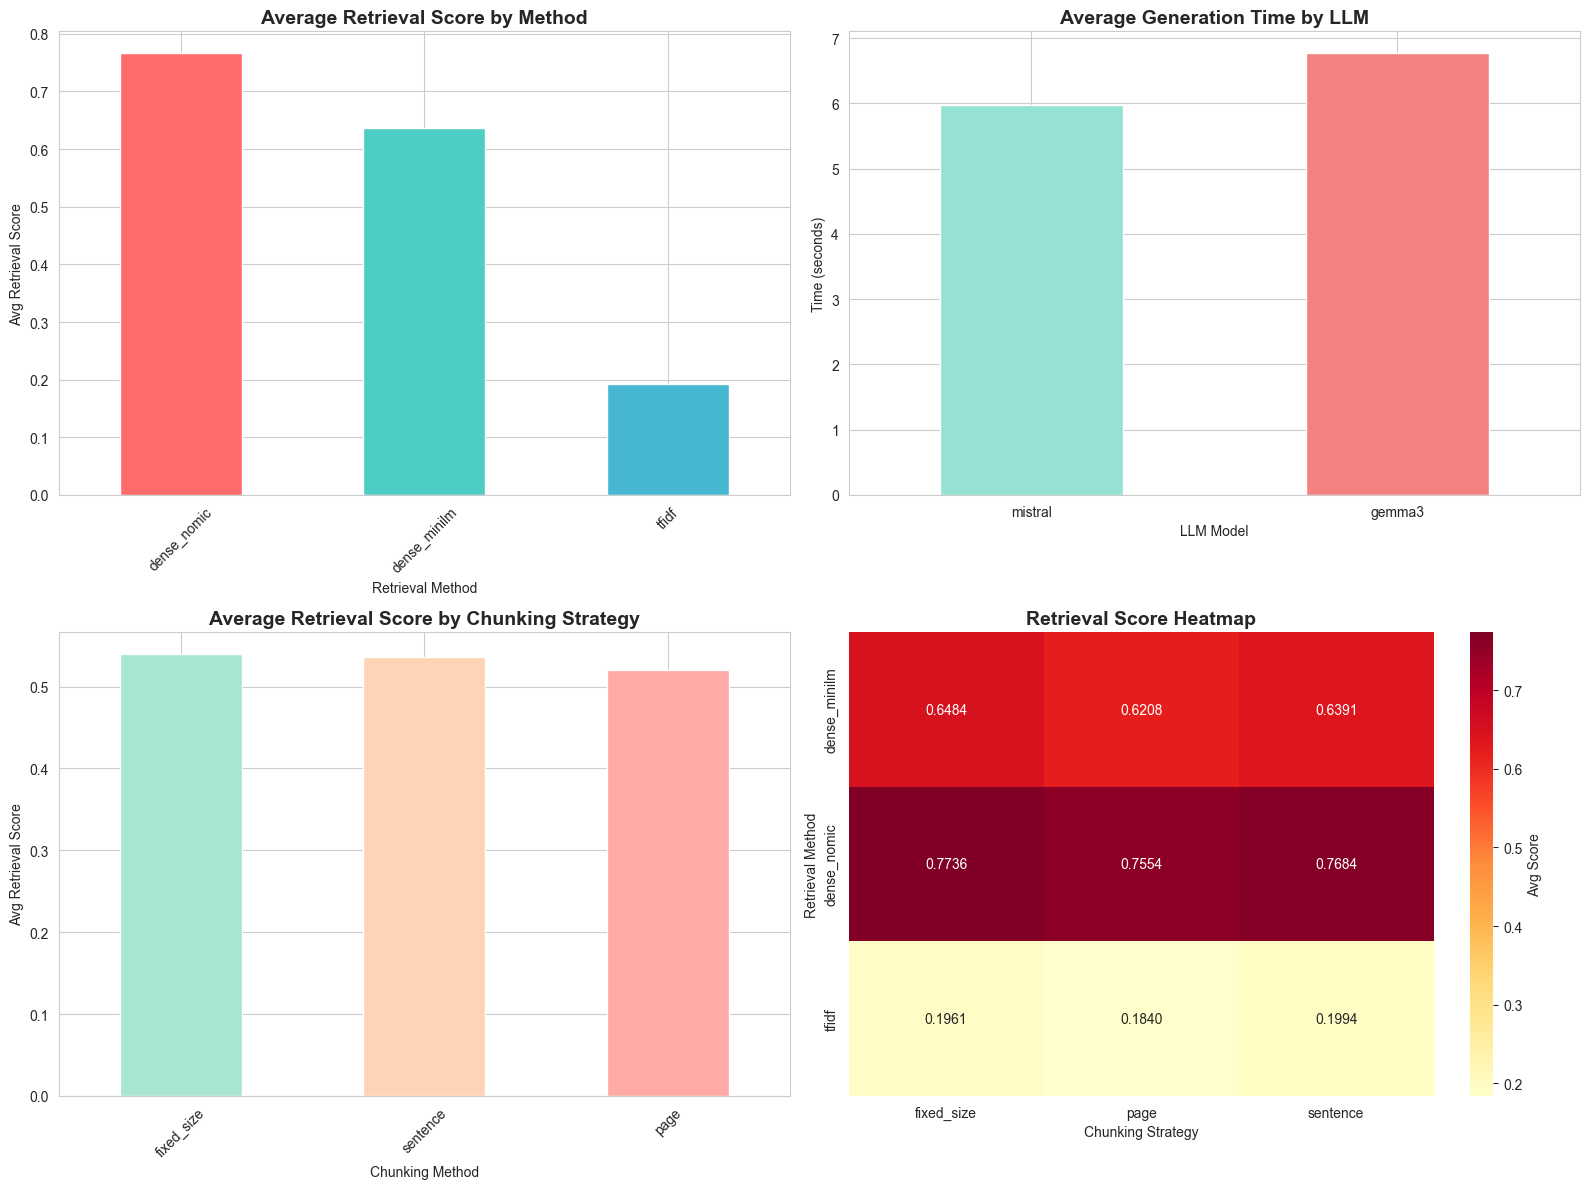


Basic visualization saved to evaluation_results\rag_evaluation_basic_20251119_011021.png


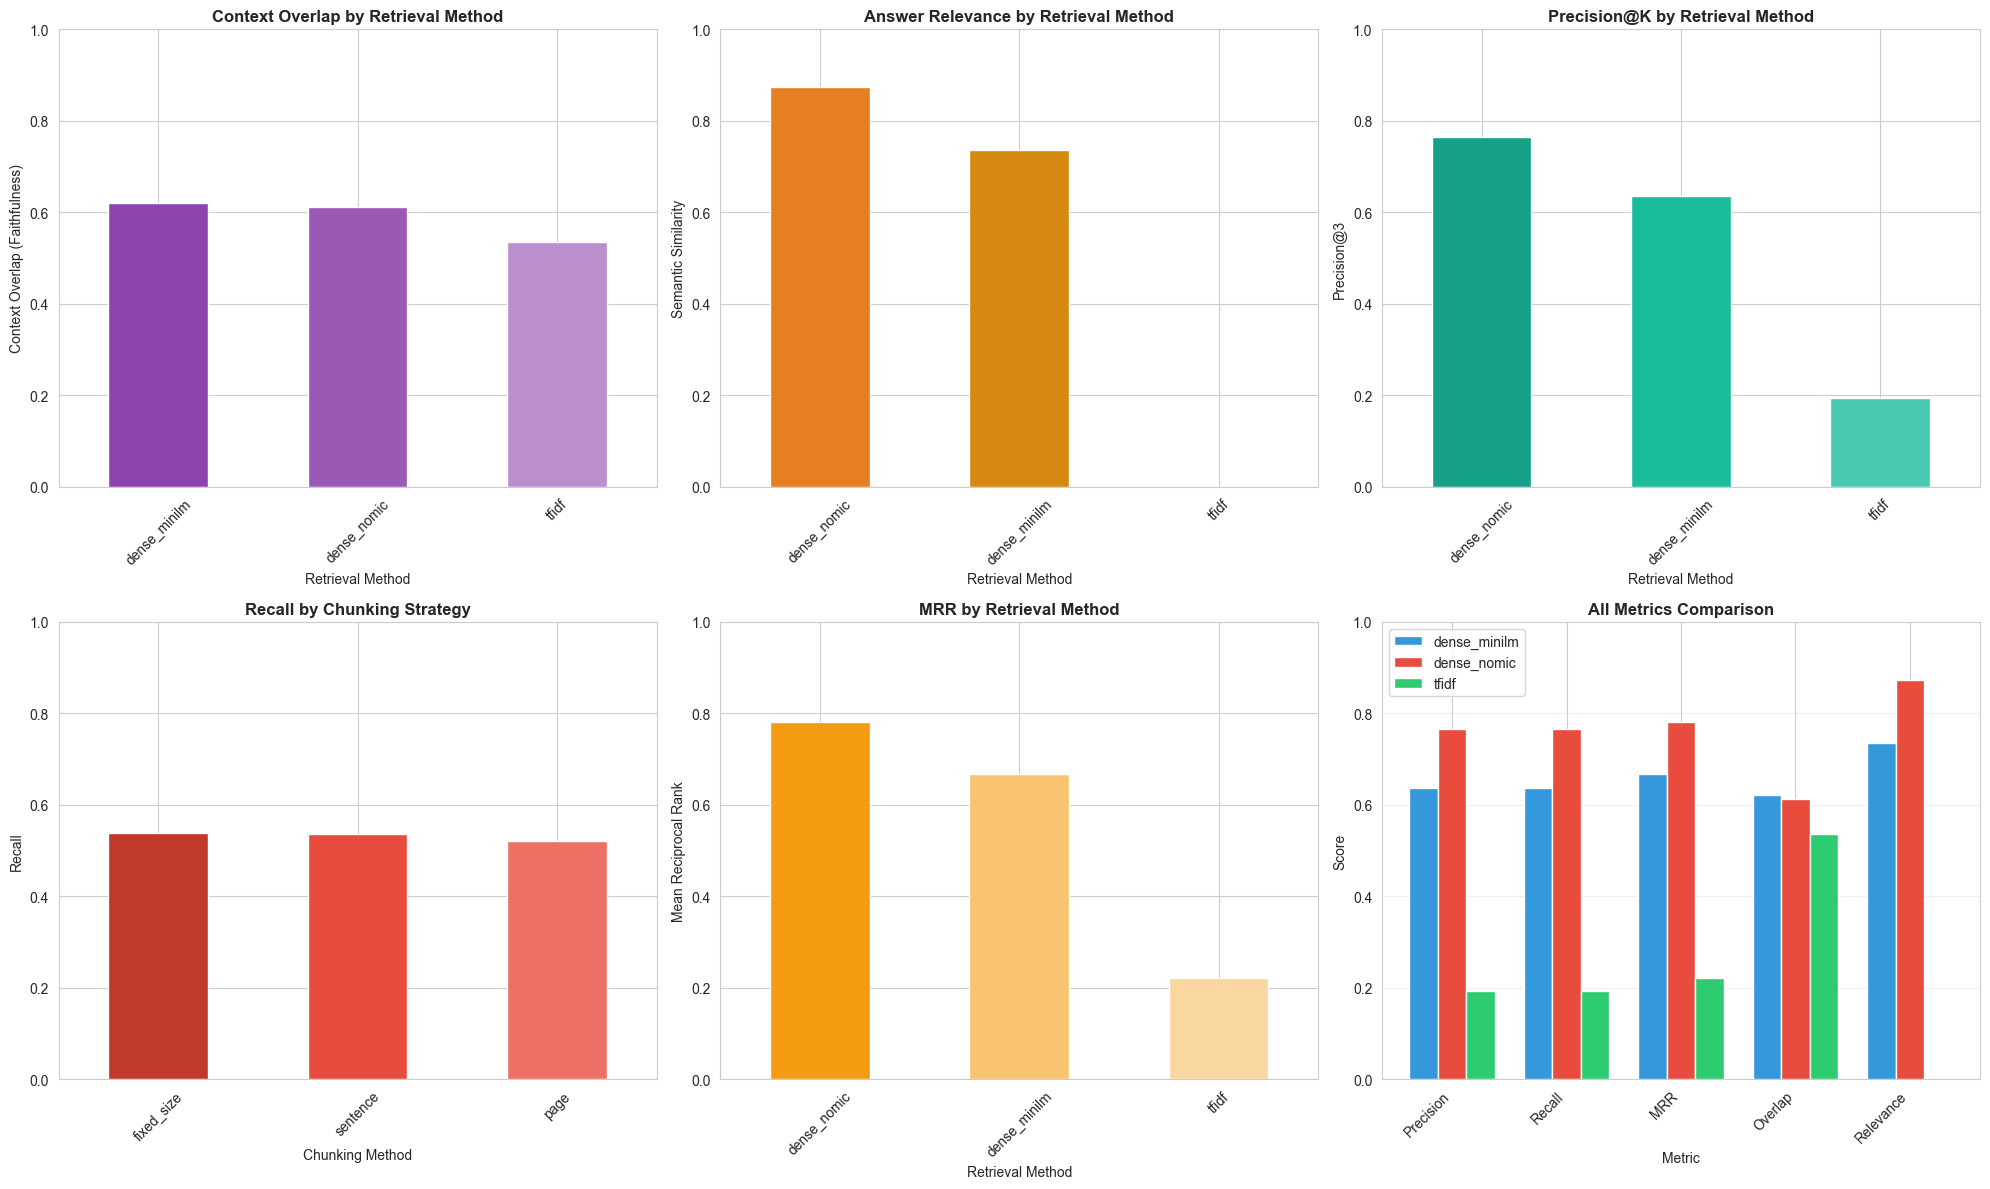

Advanced metrics visualization saved to evaluation_results\rag_evaluation_advanced_20251119_011021.png


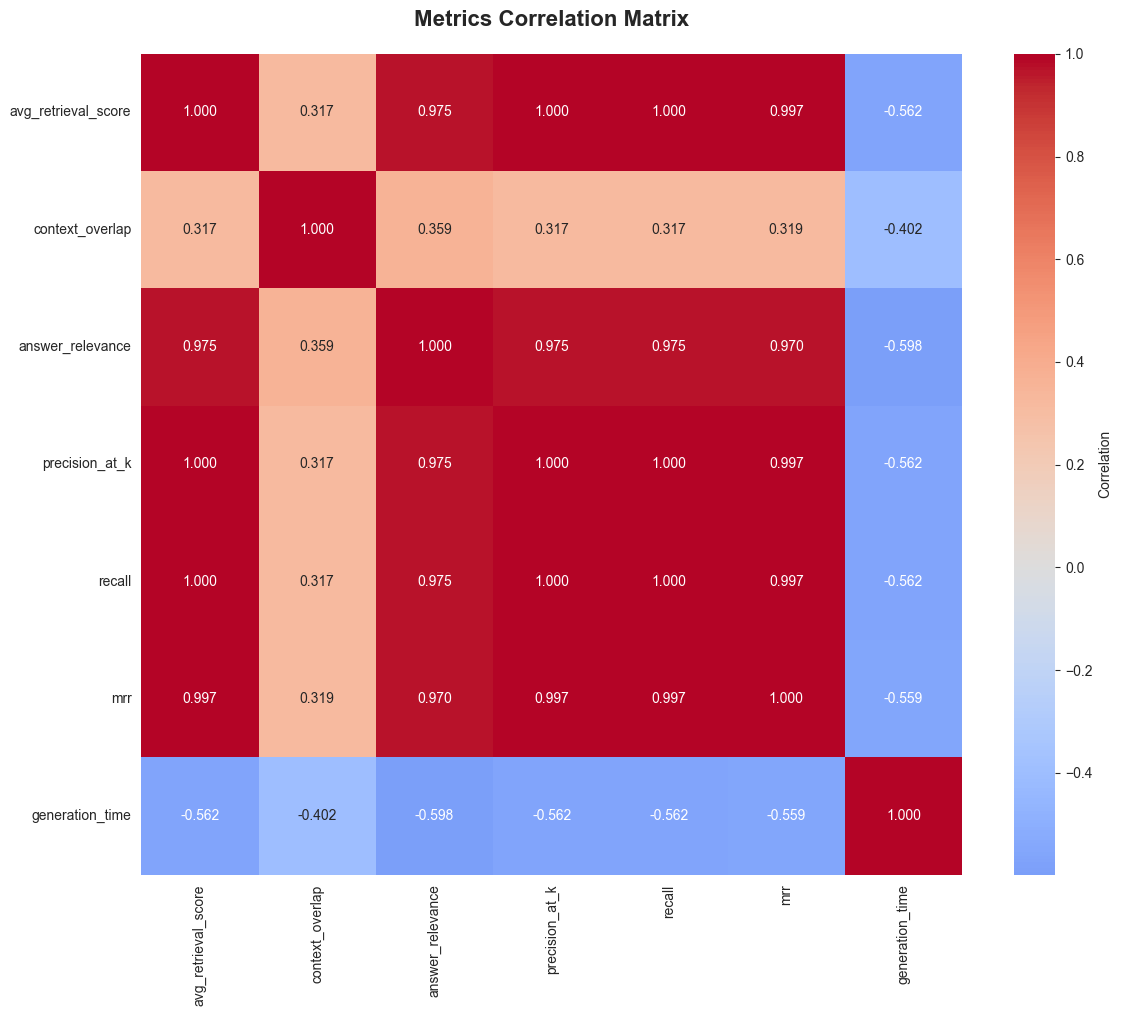

Correlation heatmap saved to evaluation_results\rag_evaluation_correlation_20251119_011021.png


In [139]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

fig1, axes = plt.subplots(2, 2, figsize=(16, 12))

ax1 = axes[0, 0]
retrieval_scores = results_df.groupby('retrieval')['avg_retrieval_score'].mean().sort_values(ascending=False)
retrieval_scores.plot(kind='bar', ax=ax1, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax1.set_title('Average Retrieval Score by Method', fontsize=14, fontweight='bold')
ax1.set_xlabel('Retrieval Method')
ax1.set_ylabel('Avg Retrieval Score')
ax1.tick_params(axis='x', rotation=45)

ax2 = axes[0, 1]
llm_times = results_df.groupby('llm')['generation_time'].mean().sort_values()
llm_times.plot(kind='bar', ax=ax2, color=['#95E1D3', '#F38181'])
ax2.set_title('Average Generation Time by LLM', fontsize=14, fontweight='bold')
ax2.set_xlabel('LLM Model')
ax2.set_ylabel('Time (seconds)')
ax2.tick_params(axis='x', rotation=0)

ax3 = axes[1, 0]
chunking_scores = results_df.groupby('chunking')['avg_retrieval_score'].mean().sort_values(ascending=False)
chunking_scores.plot(kind='bar', ax=ax3, color=['#A8E6CF', '#FFD3B6', '#FFAAA5'])
ax3.set_title('Average Retrieval Score by Chunking Strategy', fontsize=14, fontweight='bold')
ax3.set_xlabel('Chunking Method')
ax3.set_ylabel('Avg Retrieval Score')
ax3.tick_params(axis='x', rotation=45)

ax4 = axes[1, 1]
pivot_data = results_df.pivot_table(
    values='avg_retrieval_score',
    index='retrieval',
    columns='chunking',
    aggfunc='mean'
)
sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap='YlOrRd', ax=ax4, cbar_kws={'label': 'Avg Score'})
ax4.set_title('Retrieval Score Heatmap', fontsize=14, fontweight='bold')
ax4.set_xlabel('Chunking Strategy')
ax4.set_ylabel('Retrieval Method')

plt.tight_layout()
plt.savefig(RESULTS_DIR / f'rag_evaluation_basic_{timestamp}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nBasic visualization saved to {RESULTS_DIR / f'rag_evaluation_basic_{timestamp}.png'}")

fig2, axes = plt.subplots(2, 3, figsize=(20, 12))

ax1 = axes[0, 0]
context_overlap_scores = results_df.groupby('retrieval')['context_overlap'].mean().sort_values(ascending=False)
context_overlap_scores.plot(kind='bar', ax=ax1, color=['#8E44AD', '#9B59B6', '#BB8FCE'])
ax1.set_title('Context Overlap by Retrieval Method', fontsize=12, fontweight='bold')
ax1.set_xlabel('Retrieval Method')
ax1.set_ylabel('Context Overlap (Faithfulness)')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim([0, 1])

ax2 = axes[0, 1]
answer_relevance_scores = results_df.groupby('retrieval')['answer_relevance'].mean().sort_values(ascending=False)
answer_relevance_scores.plot(kind='bar', ax=ax2, color=['#E67E22', '#D68910', '#CA6F1E'])
ax2.set_title('Answer Relevance by Retrieval Method', fontsize=12, fontweight='bold')
ax2.set_xlabel('Retrieval Method')
ax2.set_ylabel('Semantic Similarity')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylim([0, 1])

ax3 = axes[0, 2]
precision_scores = results_df.groupby('retrieval')['precision_at_k'].mean().sort_values(ascending=False)
precision_scores.plot(kind='bar', ax=ax3, color=['#16A085', '#1ABC9C', '#48C9B0'])
ax3.set_title('Precision@K by Retrieval Method', fontsize=12, fontweight='bold')
ax3.set_xlabel('Retrieval Method')
ax3.set_ylabel('Precision@3')
ax3.tick_params(axis='x', rotation=45)
ax3.set_ylim([0, 1])

ax4 = axes[1, 0]
recall_scores = results_df.groupby('chunking')['recall'].mean().sort_values(ascending=False)
recall_scores.plot(kind='bar', ax=ax4, color=['#C0392B', '#E74C3C', '#EC7063'])
ax4.set_title('Recall by Chunking Strategy', fontsize=12, fontweight='bold')
ax4.set_xlabel('Chunking Method')
ax4.set_ylabel('Recall')
ax4.tick_params(axis='x', rotation=45)
ax4.set_ylim([0, 1])

ax5 = axes[1, 1]
mrr_scores = results_df.groupby('retrieval')['mrr'].mean().sort_values(ascending=False)
mrr_scores.plot(kind='bar', ax=ax5, color=['#F39C12', '#F8C471', '#FAD7A0'])
ax5.set_title('MRR by Retrieval Method', fontsize=12, fontweight='bold')
ax5.set_xlabel('Retrieval Method')
ax5.set_ylabel('Mean Reciprocal Rank')
ax5.tick_params(axis='x', rotation=45)
ax5.set_ylim([0, 1])

ax6 = axes[1, 2]
metrics_comparison = results_df.groupby('retrieval')[
    ['precision_at_k', 'recall', 'mrr', 'context_overlap', 'answer_relevance']
].mean()

x = np.arange(len(metrics_comparison.columns))
width = 0.25
colors = ['#3498DB', '#E74C3C', '#2ECC71']

for i, (method, row) in enumerate(metrics_comparison.iterrows()):
    ax6.bar(x + i*width, row.values, width, label=method, color=colors[i % len(colors)])

ax6.set_title('All Metrics Comparison', fontsize=12, fontweight='bold')
ax6.set_xlabel('Metric')
ax6.set_ylabel('Score')
ax6.set_xticks(x + width)
ax6.set_xticklabels(['Precision', 'Recall', 'MRR', 'Overlap', 'Relevance'], rotation=45, ha='right')
ax6.legend()
ax6.set_ylim([0, 1])
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / f'rag_evaluation_advanced_{timestamp}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Advanced metrics visualization saved to {RESULTS_DIR / f'rag_evaluation_advanced_{timestamp}.png'}")

fig3, ax = plt.subplots(figsize=(12, 10))

correlation_metrics = results_df[[
    'avg_retrieval_score', 'context_overlap', 'answer_relevance', 
    'precision_at_k', 'recall', 'mrr', 'generation_time'
]].corr()

sns.heatmap(correlation_metrics, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, ax=ax, cbar_kws={'label': 'Correlation'})
ax.set_title('Metrics Correlation Matrix', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(RESULTS_DIR / f'rag_evaluation_correlation_{timestamp}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Correlation heatmap saved to {RESULTS_DIR / f'rag_evaluation_correlation_{timestamp}.png'}")

## 15. Summary Report

## 14.5 LLM Comparison: Which Model Performs Better?

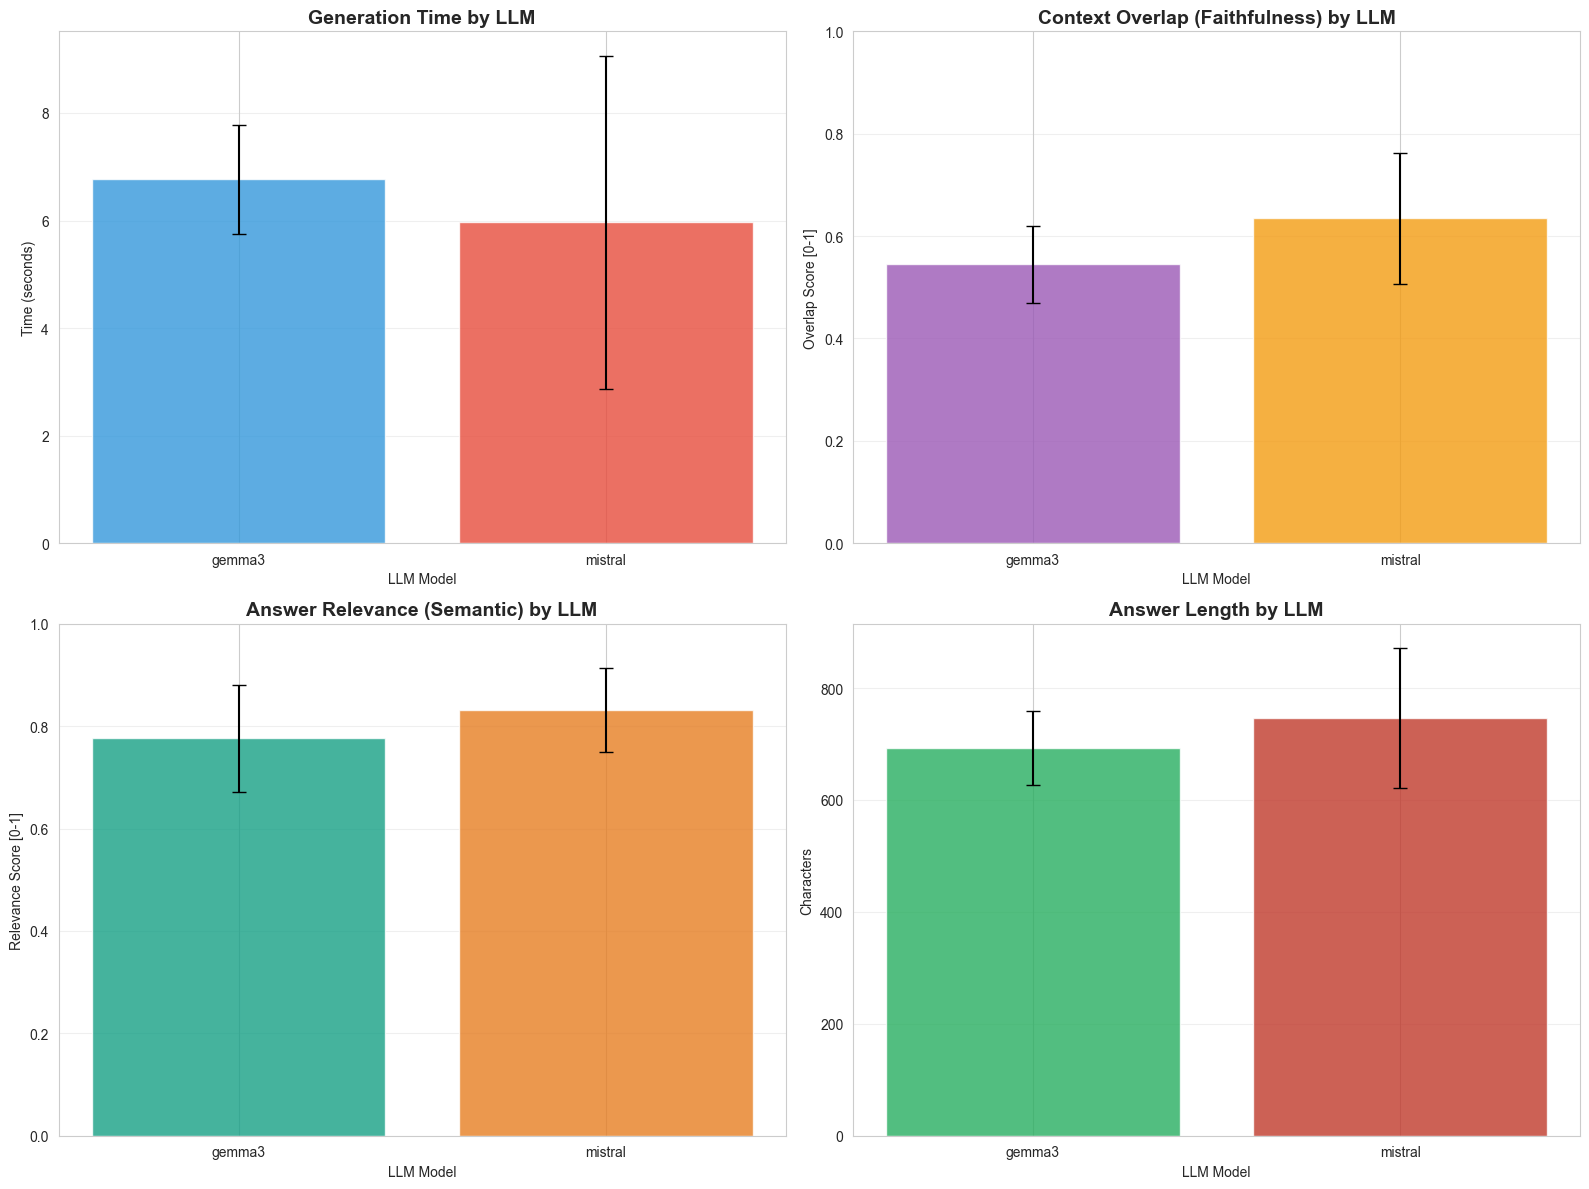


LLM comparison visualization saved to evaluation_results\rag_evaluation_llm_comparison_20251119_011021.png
LLM PERFORMANCE COMPARISON

GEMMA3:
  Generation Time:    6.77s (±1.01s)
  Context Overlap:    0.545 (±0.075)
  Answer Relevance:   0.776 (±0.104)
  Answer Length:      693 chars (±66)
  Total Evaluations:  90

MISTRAL:
  Generation Time:    5.97s (±3.09s)
  Context Overlap:    0.634 (±0.128)
  Answer Relevance:   0.832 (±0.082)
  Answer Length:      746 chars (±125)
  Total Evaluations:  90


In [140]:
fig4, axes = plt.subplots(2, 2, figsize=(16, 12))

ax1 = axes[0, 0]
llm_time_comparison = results_df.groupby('llm')['generation_time'].agg(['mean', 'std'])
x_pos = np.arange(len(llm_time_comparison))
ax1.bar(x_pos, llm_time_comparison['mean'], yerr=llm_time_comparison['std'], 
        capsize=5, color=['#3498DB', '#E74C3C'], alpha=0.8)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(llm_time_comparison.index)
ax1.set_title('Generation Time by LLM', fontsize=14, fontweight='bold')
ax1.set_xlabel('LLM Model')
ax1.set_ylabel('Time (seconds)')
ax1.grid(axis='y', alpha=0.3)

ax2 = axes[0, 1]
llm_overlap = results_df.groupby('llm')['context_overlap'].agg(['mean', 'std'])
x_pos = np.arange(len(llm_overlap))
ax2.bar(x_pos, llm_overlap['mean'], yerr=llm_overlap['std'], 
        capsize=5, color=['#9B59B6', '#F39C12'], alpha=0.8)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(llm_overlap.index)
ax2.set_title('Context Overlap (Faithfulness) by LLM', fontsize=14, fontweight='bold')
ax2.set_xlabel('LLM Model')
ax2.set_ylabel('Overlap Score [0-1]')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)

ax3 = axes[1, 0]
embedding_results = results_df[results_df['embedding'] != 'none']
llm_relevance = embedding_results.groupby('llm')['answer_relevance'].agg(['mean', 'std'])
x_pos = np.arange(len(llm_relevance))
ax3.bar(x_pos, llm_relevance['mean'], yerr=llm_relevance['std'], 
        capsize=5, color=['#16A085', '#E67E22'], alpha=0.8)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(llm_relevance.index)
ax3.set_title('Answer Relevance (Semantic) by LLM', fontsize=14, fontweight='bold')
ax3.set_xlabel('LLM Model')
ax3.set_ylabel('Relevance Score [0-1]')
ax3.set_ylim([0, 1])
ax3.grid(axis='y', alpha=0.3)

ax4 = axes[1, 1]
llm_length = results_df.groupby('llm')['answer_length'].agg(['mean', 'std'])
x_pos = np.arange(len(llm_length))
ax4.bar(x_pos, llm_length['mean'], yerr=llm_length['std'], 
        capsize=5, color=['#27AE60', '#C0392B'], alpha=0.8)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(llm_length.index)
ax4.set_title('Answer Length by LLM', fontsize=14, fontweight='bold')
ax4.set_xlabel('LLM Model')
ax4.set_ylabel('Characters')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / f'rag_evaluation_llm_comparison_{timestamp}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nLLM comparison visualization saved to {RESULTS_DIR / f'rag_evaluation_llm_comparison_{timestamp}.png'}")

print("LLM PERFORMANCE COMPARISON")

for llm in results_df['llm'].unique():
    llm_data = results_df[results_df['llm'] == llm]
    llm_emb_data = embedding_results[embedding_results['llm'] == llm]
    
    print(f"\n{llm.upper()}:")
    print(f"  Generation Time:    {llm_data['generation_time'].mean():.2f}s (±{llm_data['generation_time'].std():.2f}s)")
    print(f"  Context Overlap:    {llm_data['context_overlap'].mean():.3f} (±{llm_data['context_overlap'].std():.3f})")
    if len(llm_emb_data) > 0:
        print(f"  Answer Relevance:   {llm_emb_data['answer_relevance'].mean():.3f} (±{llm_emb_data['answer_relevance'].std():.3f})")
    print(f"  Answer Length:      {llm_data['answer_length'].mean():.0f} chars (±{llm_data['answer_length'].std():.0f})")
    print(f"  Total Evaluations:  {len(llm_data)}")

In [144]:
print("\nDATASET:")
print(f"  Source: US Army Field Manuals (FM 21-76, FM 3-05-70)")
print(f"  Total pages: 881")
print(f"  Test questions: {len(test_questions_subset)}")

print("\nRETRIEVAL METHODS TESTED:")
for method in RETRIEVAL_METHODS:
    avg_score = results_df[results_df['retrieval'] == method]['avg_retrieval_score'].mean()
    precision = results_df[results_df['retrieval'] == method]['precision_at_k'].mean()
    mrr = results_df[results_df['retrieval'] == method]['mrr'].mean()
    print(f"  • {method:20s}: retrieval={avg_score:.4f}, precision={precision:.4f}, MRR={mrr:.4f}")

print("\nCHUNKING STRATEGIES TESTED:")
for method in CHUNKING_METHODS:
    avg_score = results_df[results_df['chunking'] == method]['avg_retrieval_score'].mean()
    recall = results_df[results_df['chunking'] == method]['recall'].mean()
    chunks_count = len(chunks_data[method])
    print(f"  • {method:20s}: {chunks_count:4d} chunks, retrieval={avg_score:.4f}, recall={recall:.4f}")

print("\nLLMs TESTED:")
for llm in results_df['llm'].unique():
    avg_time = results_df[results_df['llm'] == llm]['generation_time'].mean()
    avg_len = results_df[results_df['llm'] == llm]['answer_length'].mean()
    overlap = results_df[results_df['llm'] == llm]['context_overlap'].mean()
    relevance = results_df[results_df['llm'] == llm]['answer_relevance'].mean()
    print(f"  • {llm:20s}: time={avg_time:.2f}s, length={avg_len:.0f}, overlap={overlap:.3f}, relevance={relevance:.3f}")

print("\nEMBEDDINGS TESTED:")
for emb in results_df['embedding'].unique():
    avg_score = results_df[results_df['embedding'] == emb]['avg_retrieval_score'].mean()
    precision = results_df[results_df['embedding'] == emb]['precision_at_k'].mean()
    mrr = results_df[results_df['embedding'] == emb]['mrr'].mean()
    print(f"  • {emb:20s}: retrieval={avg_score:.4f}, precision={precision:.4f}, MRR={mrr:.4f}")

print("\nFULL CONFIGS TESTED:")
for cfg in results_df['config'].unique():
    count = len(results_df[results_df['config'] == cfg])
    avg_score = results_df[results_df['config'] == cfg]['avg_retrieval_score'].mean()
    avg_time = results_df[results_df['config'] == cfg]['generation_time'].mean()
    print(f"  • {cfg:20s}: {count:3d} evals, retrieval={avg_score:.4f}, time={avg_time:.2f}s")

best_idx = results_df['avg_retrieval_score'].idxmax()
best = results_df.loc[best_idx]

print("\nBEST CONFIGURATION (highest retrieval score):")
print(f"  Retrieval: {best['retrieval']}")
print(f"  Chunking: {best['chunking']}")
print(f"  LLM: {best['llm']}")
print(f"  Score: {best['avg_retrieval_score']:.4f}")
print(f"  Generation time: {best['generation_time']:.2f}s")

fastest_idx = results_df['generation_time'].idxmin()
fastest = results_df.loc[fastest_idx]

print("\nFASTEST CONFIGURATION:")
print(f"  Retrieval: {fastest['retrieval']}")
print(f"  Chunking: {fastest['chunking']}")
print(f"  LLM: {fastest['llm']}")
print(f"  Score: {fastest['avg_retrieval_score']:.4f}")
print(f"  Generation time: {fastest['generation_time']:.2f}s")

print("ABSOLUTE BEST CONFIGURATION")

best_chunking = results_df.groupby('chunking')['avg_retrieval_score'].mean().idxmax()
best_retrieval = results_df.groupby('retrieval')['avg_retrieval_score'].mean().idxmax()
best_llm_overlap = results_df.groupby('llm')['context_overlap'].mean().idxmax()
best_llm_speed = results_df.groupby('llm')['generation_time'].mean().idxmin()

best_combo = results_df.groupby(['chunking', 'retrieval', 'llm']).agg({
    'avg_retrieval_score': 'mean',
    'context_overlap': 'mean',
    'generation_time': 'mean'
}).reset_index()

best_combo['combined_score'] = (
    best_combo['avg_retrieval_score'] * 0.6 +  
    best_combo['context_overlap'] * 0.4
)

optimal = best_combo.loc[best_combo['combined_score'].idxmax()]

print(f"\nBest Chunking Strategy:  {best_chunking}")
print(f"Best Retrieval Method:   {best_retrieval}")
print(f"Best LLM (faithfulness): {best_llm_overlap}")

print(f"\nOPTIMAL CONFIGURATION (balanced score):")
print(f"   Chunking:        {optimal['chunking']}")
print(f"   Retrieval:       {optimal['retrieval']}")
print(f"   LLM:             {optimal['llm']}")
print(f"\n   Metrics:")
print(f"   Retrieval Score:   {optimal['avg_retrieval_score']:.4f}")
print(f"   Context Overlap:   {optimal['context_overlap']:.3f}")
print(f"   Generation Time:   {optimal['generation_time']:.2f}s")
print(f"   Combined Score:    {optimal['combined_score']:.4f}")
print("\n   This configuration balances retrieval quality (60%) and faithfulness (40%)")



DATASET:
  Source: US Army Field Manuals (FM 21-76, FM 3-05-70)
  Total pages: 881
  Test questions: 10

RETRIEVAL METHODS TESTED:
  • tfidf               : retrieval=0.1932, precision=0.1932, MRR=0.2203
  • dense_nomic         : retrieval=0.7658, precision=0.7658, MRR=0.7803
  • dense_minilm        : retrieval=0.6361, precision=0.6361, MRR=0.6676

CHUNKING STRATEGIES TESTED:
  • page                :  881 chunks, retrieval=0.5201, recall=0.5201
  • fixed_size          : 1540 chunks, retrieval=0.5394, recall=0.5394
  • sentence            : 1577 chunks, retrieval=0.5356, recall=0.5356

LLMs TESTED:
  • gemma3              : time=6.77s, length=693, overlap=0.545, relevance=0.518
  • mistral             : time=5.97s, length=746, overlap=0.634, relevance=0.555

EMBEDDINGS TESTED:
  • none                : retrieval=0.1932, precision=0.1932, MRR=0.2203
  • nomic               : retrieval=0.7658, precision=0.7658, MRR=0.7803
  • minilm              : retrieval=0.6361, precision=0.6361, MRR